In [251]:
%matplotlib inline

import pickle

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scikit imports
from sklearn.datasets import make_classification, make_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

# Overfitting notebook

Notebook for overfitting simulation and notes.

## Functions

In [187]:
def generate_class_data(n_train, n_test, **kwargs):
    """Creates synthetic dataset for classification.
    
    Mainly a wrapper for sklearn.datasets.make_classification.
    
    Args:
        n_train (int): number of training samples
        n_test (int): number of testing samples
    
    Returns:
        (np.ndarray, np.ndarray, np.ndarray, np.ndarray): train_X, train_y, test_X, test_y
    
    """
    
    n_samples = n_train + n_test
    
    X, y = make_classification(n_samples = n_samples, **kwargs)
    
    train_X = X[:n_train, :]
    train_y= y[:n_train]

    test_X = X[n_train:, :]
    test_y = y[n_train:]
    
    return train_X, train_y, test_X, test_y


def generate_reg_data(n_train, n_test, **kwargs):
    """Creates a synthetic dataset for regression.
    
    Mainly a wrapper for sklearn.datasets.make_regression.
    
    Args:
        n_train (int): number of training samples
        n_test (int): number of testing samples
    
    Returns:
        (np.ndarray, np.ndarray, np.ndarray, np.ndarray): train_X, train_y, test_X, test_y
    """

    n_samples = n_train + n_test
    reg_X, reg_y = make_regression(n_samples=n_samples, **kwargs)

    reg_train_X = reg_X[:n_train, :]
    reg_train_y= reg_y[:n_train]

    reg_test_X = reg_X[n_train:, :]
    reg_test_y = reg_y[n_train:]

    return reg_train_X, reg_train_y, reg_test_X, reg_test_y
    
    
def generate_noise_class_data(n_train, n_test, n_features, p=0.5, random_state=0):
    """Generates a random classification data set.
    
    Features are drawn from a multivariate normal with [0,1] random mean and unit variance.
    
    Labels are drawn from a Bernoulli distribution with P(yes) = p.
    
    Args:
        n_train (int): number of training samples
        n_test (int): number of testing samples
        n_features (int): number of features 
        p: Bernoulli parameter
        random_state (int): random state for reproducibility
        
    Returns:
        (np.ndarray, np.ndarray, np.ndarray, np.ndarray): train_X, train_y, test_X, test_y
    """
    
    np.random.seed(random_state)
    train_X = np.random.multivariate_normal(np.zeros((n_features)), 
                                      cov=np.eye(n_features),
                                      size=n_train)
    
    train_y = np.random.rand(n_train) > p
    
    test_X =  np.random.multivariate_normal(np.zeros((n_features)), 
                                      cov=np.eye(n_features),
                                      size=n_test)
    test_y = np.random.rand(n_test) > p
    
    return train_X, train_y, test_X, test_y


def simulate_no_label_X(pipelines, n_feats, n_trials, n_samples, classification=True):
    """Runs an n_trials simulation the given pipeline models on unlabeled, randomly drawn X.
    
    Features are sampled from a multivariate Gaussian with random [0,1] means and unit variance.
    
    Args:
        pipelines (list): list of sklearn.pipeline.Pipelines with trained models
        n_feats (int): the number of features for the Xs
        n_trials (int): number of trials to run.
        n_samples (int): number of samples to draw per run.
        classification (bool): whether to evaluate with classification or regression metrics.
        
    Returns:
        (list, list): list of mean probabilities predicting label 1, list of corresponding std dev
    """
    # n_trials by n_models
    #stds = np.zeros((n_trials, len(pipelines)))
    pred_probs = np.zeros((n_trials, len(pipelines)))
    
    for trial in range(n_trials):
        no_label_X = np.random.multivariate_normal(np.random.rand((n_feats)), 
                                           cov=np.eye(n_feats),
                                           size=n_samples)
        
        for pipe_idx, pipe in enumerate(pipelines):
            pred_prob = np.mean(pipe.predict_proba(no_label_X)[:, 1])
            pred_probs[trial, pipe_idx] = pred_prob
        
        print("trial {} complete".format(trial))
    mean_probs = np.mean(pred_probs, axis=0)
    std_probs = np.std(pred_probs, axis=0)
    assert len(pipelines) == len(mean_probs)
    assert len(pipelines) == len(std_probs)
    
    return pred_probs, mean_probs, std_probs




## Classification

### `make_classification`

- clusters of points normally distributed with $\sigma=1$ about vertices of an `n_informative`-dimensional hypercube with sides of length 2*`class_sep`

### Sandbox

#### Polynomial Logistic Regression

In [91]:
# features
n_informative = 4
n_redundant = 0
n_total_feats = 20

# samples
n_train = 1000
n_test = 500

# class parameters
n_classes = 2
weights = None#[.2, .8] # defaults to 50/50 split

# output params
shuffle = True
random_state = 0
class_sep = 1
n_clusters_per_class = 4

X, y = make_classification(
                            n_samples = n_train + n_test,
                            n_features = n_total_feats,
                            n_informative = n_informative,
                            n_redundant = n_redundant,
                            n_classes = n_classes,
                            weights = weights,
                            shuffle = shuffle,
                            random_state = random_state,
                            class_sep = class_sep)

end_idx_0 = n_train // 2
start_idx_1 = (n_train // 2) + (n_test // 2)
end_idx_1 = n_train + (n_test // 2)
train_data = np.append(X[:end_idx_0, :], X[start_idx_1:end_idx_1, :], 0)
train_data = np.c_[train_data, np.append(y[:end_idx_0], y[start_idx_1:end_idx_1])]

test_data = np.append(X[end_idx_0:start_idx_1, :], X[end_idx_1:, :], 0)
test_data = np.c_[test_data, np.append(y[end_idx_0:start_idx_1], y[end_idx_1:])]

train_X = train_data[:, :-1]
train_y = train_data[:, -1]

test_X = test_data[:, :-1]
test_y = test_data[:, -1]

In [92]:
print(sum(train_y))
print(sum(test_y))

500.0
249.0


In [93]:
degrees = np.arange(1,9)


train_acc = []
test_proba = []
test_acc = []
pipelines = []
for deg in degrees:
    poly_features = PolynomialFeatures(degree=deg, 
                                       include_bias=False,
                                       interaction_only=True)
    lr_model = LogisticRegression(solver='lbfgs', 
                                  penalty='none', 
                                  #C=1000,
                                  random_state=random_state,
                                  n_jobs=-1)
    lr_pipeline = Pipeline([("polynomial_features", poly_features),
                           ("logistic_regression", lr_model)])
    
    lr_pipeline.fit(train_X.copy(), train_y.copy())
    
    pipelines.append(lr_pipeline)
    
    train_acc.append(accuracy_score(train_y, lr_pipeline.predict(train_X)))
    test_proba.append(np.mean(lr_pipeline.predict_proba(test_X)[:, 0]))
    test_acc.append(accuracy_score(test_y, lr_pipeline.predict(test_X)))
    print(deg)
    
print(test_acc)

1
2
3
4
5
6
7
8
[0.716, 0.724, 0.71, 0.64, 0.656, 0.636, 0.618, 0.606]


In [94]:
train_acc

[0.715, 0.914, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [95]:
test_proba

[0.4849283679191724,
 0.49541346849970264,
 0.5062807938941694,
 0.47583783890711684,
 0.49466349222582257,
 0.48819288803171335,
 0.48603476663320055,
 0.48256425418118604]

In [96]:
np.max(train_X)

4.909210327846378

In [97]:
no_label_X = np.random.multivariate_normal(np.random.rand((n_total_feats)), 
                                   cov=np.eye(n_total_feats),
                                   size=n_test)

In [98]:
test_proba = []
test_pred = []
for pipe_idx, pipe in enumerate(pipelines):
    pred_prob = pipe.predict_proba(no_label_X)
    #print(pred_prob.shape)
    #print(pred_prob[:5,:])
    test_proba.append(np.mean(pred_prob[:, 1]))
    test_pred.append(np.sum(pipe.predict(no_label_X)))

In [99]:
test_proba

[0.7645429064670288,
 0.6172751203051686,
 0.5292817102255765,
 0.48139547610391137,
 0.46417871226913066,
 0.46438994302869885,
 0.4527785993475524,
 0.47026772159779057]

In [100]:
test_pred

[468.0, 314.0, 265.0, 241.0, 232.0, 229.0, 223.0, 229.0]

In [101]:
for pipe in pipelines:
    print(pipe['polynomial_features'].n_output_features_)

20
210
1350
6195
21699
60459
137979
263949


#### Decision Tree

In [285]:
# features
n_informative = 10
n_redundant = 0
n_total_feats = 1000

# samples
n_train = 1000
n_test = 500

# class parameters
n_classes = 2
weights = None#[.2, .8] # defaults to 50/50 split

# output params
shuffle = True
random_state = 0
class_sep = 1
n_clusters_per_class = 1

X, y = make_classification(
                            n_samples = n_train + n_test,
                            n_features = n_total_feats,
                            n_informative = n_informative,
                            n_redundant = n_redundant,
                            n_classes = n_classes,
                            weights = weights,
                            shuffle = shuffle,
                            random_state = random_state,
                            class_sep = class_sep)

end_idx_0 = n_train // 2
start_idx_1 = (n_train // 2) + (n_test // 2)
end_idx_1 = n_train + (n_test // 2)
train_data = np.append(X[:end_idx_0, :], X[start_idx_1:end_idx_1, :], 0)
train_data = np.c_[train_data, np.append(y[:end_idx_0], y[start_idx_1:end_idx_1])]

test_data = np.append(X[end_idx_0:start_idx_1, :], X[end_idx_1:, :], 0)
test_data = np.c_[test_data, np.append(y[end_idx_0:start_idx_1], y[end_idx_1:])]

class_train_X = train_data[:, :-1]
class_train_y = train_data[:, -1]

class_test_X = test_data[:, :-1]
class_test_y = test_data[:, -1]

In [286]:
depths = [x for x in range(1,20)] + [None]
class_trees = []
class_train_acc = []
class_test_acc = []

for depth in depths:
    class_tree = DecisionTreeClassifier(max_depth=depth)
    class_tree.fit(class_train_X.copy(), class_train_y.copy())
    class_trees.append(class_tree)
    
    class_train_acc.append(accuracy_score(class_train_y, class_tree.predict(class_train_X)))
    #class_test_proba.append(np.mean(class_tree.predict_proba(class_test_X)[:, 0]))
    class_test_acc.append(accuracy_score(class_test_y, class_tree.predict(class_test_X)))
    
print(class_test_acc)

[0.598, 0.684, 0.692, 0.724, 0.722, 0.72, 0.698, 0.702, 0.716, 0.678, 0.712, 0.69, 0.684, 0.696, 0.682, 0.694, 0.692, 0.654, 0.696, 0.684]


In [287]:
class_train_acc

[0.643,
 0.738,
 0.771,
 0.833,
 0.884,
 0.924,
 0.952,
 0.974,
 0.981,
 0.991,
 0.994,
 0.997,
 0.998,
 0.999,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

### Notes

- generate data from two separate distributions
- plots as $p$ increases
- train on 50/50 split
- plots of underfit, "fit," and overfit predictions as the distribution of out-of-sample data goes from 0 to 1 in terms of labels
- use `make_classification`
- use pipeline of polynomial features
- TODO do the out-of-sample people come from a different data distribution?

### Functions

In [102]:
n_trials = 50
n_samples = 500
pred_probs, mean_p, std_p = simulate_no_label_X(pipelines, 
                                                n_total_feats, 
                                                n_trials, 
                                                n_samples)

trial 0 complete
trial 1 complete
trial 2 complete
trial 3 complete
trial 4 complete
trial 5 complete
trial 6 complete
trial 7 complete
trial 8 complete
trial 9 complete
trial 10 complete
trial 11 complete
trial 12 complete
trial 13 complete
trial 14 complete
trial 15 complete
trial 16 complete
trial 17 complete
trial 18 complete
trial 19 complete
trial 20 complete
trial 21 complete
trial 22 complete
trial 23 complete
trial 24 complete
trial 25 complete
trial 26 complete
trial 27 complete
trial 28 complete
trial 29 complete
trial 30 complete
trial 31 complete
trial 32 complete
trial 33 complete
trial 34 complete
trial 35 complete
trial 36 complete
trial 37 complete
trial 38 complete
trial 39 complete
trial 40 complete
trial 41 complete
trial 42 complete
trial 43 complete
trial 44 complete
trial 45 complete
trial 46 complete
trial 47 complete
trial 48 complete
trial 49 complete


### Plots

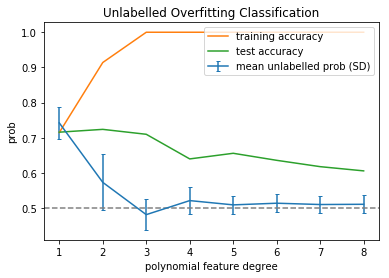

In [105]:
x = np.arange(1,9)

#sns.pointplot(x, mean_p)
plt.errorbar(x, mean_p, yerr=std_p, #/ np.sqrt(n_trials), 
             capsize=2, label="mean unlabelled prob (SD)")
plt.plot(x, train_acc, label="training accuracy")
plt.plot(x, test_acc, label="test accuracy")
plt.ylabel("prob")
plt.xlabel("polynomial feature degree")
plt.axhline(y=0.5, ls='--', color='grey')
plt.legend(loc='upper right')
plt.title("Unlabelled Overfitting Classification")
#plt.savefig("../figures/overfit_classification_1000.png", dpi=300)

- 4 informative features, 20 total
- $n=1000$ training set size (50/50 split)
- $n=500$ test set size

## Regression

### Sandbox

#### Decision Tree

In [354]:
random_state = 2
effective_rank = 20
n_informative = 100
n_features = 1000
n_train = 100
n_test = 500
tail_strength = 0.5
n_samples = n_train + n_test
noise = 0
reg_X, reg_y = make_regression(n_samples=n_samples,
                               n_features=n_features,
                               n_informative=n_informative,
                               effective_rank=effective_rank,
                               tail_strength=tail_strength,
                               noise=noise,
                               random_state=random_state)

reg_train_X = reg_X[:n_train, :]
reg_train_y= reg_y[:n_train]

reg_test_X = reg_X[n_train:, :]
reg_test_y = reg_y[n_train:]

In [355]:
depths = [x for x in range(1,20)] + [None]
reg_trees = []
reg_train_mse = []
reg_test_mse = []

for depth in depths:
    reg_tree = DecisionTreeRegressor(max_depth=depth)
    reg_tree.fit(reg_train_X.copy(), reg_train_y.copy())
    reg_trees.append(reg_tree)
    
    reg_train_mse.append(mean_squared_error(reg_train_y, reg_tree.predict(reg_train_X)))
    #reg_test_proba.append(np.mean(reg_tree.predict_proba(reg_test_X)[:, 0]))
    reg_test_mse.append(mean_squared_error(reg_test_y, reg_tree.predict(reg_test_X)))
    
print(reg_test_mse)

[21.11094864635704, 22.966908354189123, 26.52979591576371, 26.54713604681531, 28.16707979670335, 30.107564065001544, 30.915650205034083, 31.852926789370684, 30.81455752305023, 30.19268390508701, 31.577784351217094, 29.758263888178053, 36.17631855698449, 32.12861953055407, 34.93895006067893, 30.641698904474552, 30.28661764372878, 31.147869486970453, 33.52100923554806, 32.0946558619357]


In [356]:
reg_train_mse

[16.71679222608997,
 12.614358786361755,
 8.22855580288373,
 4.7765937515229675,
 2.2624283049318468,
 0.8796912532669807,
 0.25030321726066285,
 0.05588195834413568,
 0.00614316180960854,
 0.0006853136448682055,
 1.5275787118480288e-06,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [357]:
no_label_X = np.random.multivariate_normal(np.random.rand((n_features)), 
                                   cov=np.eye(n_features),
                                   size=n_test)

In [358]:
reg_no_label_std = []
reg_no_label_mean = []
for tree_idx, tree in enumerate(reg_trees):
    predictions = tree.predict(no_label_X)
    reg_no_label_mean.append(np.mean(predictions))
    reg_no_label_std.append(np.std(predictions))

In [360]:
reg_no_label_std

[1.9509496781845381,
 3.1337077007340626,
 5.734477688862062,
 6.2755579078981345,
 6.023955955721974,
 7.215375499376987,
 5.100761892740427,
 6.802205612973915,
 5.091478660992177,
 5.656430698781644,
 5.983778308492219,
 5.112086918771842,
 6.788058434189682,
 6.523363808121618,
 5.861638468312976,
 5.5743684148997685,
 6.872277900693816,
 6.311726116168101,
 6.3245188503367835,
 6.579655641885196]

#### SVM

In [361]:
from sklearn import svm

gammas = [0.001, 0.1] + list(np.arange(1,100,10))
reg_svms = []
reg_train_mse = []
reg_test_mse = []

for gamma in gammas:
    reg_svm = svm.SVR(gamma=gamma, C=100)
    reg_svm.fit(reg_train_X.copy(), reg_train_y.copy())
    reg_svms.append(reg_svm)
    
    reg_train_mse.append(mean_squared_error(reg_train_y, reg_svm.predict(reg_train_X)))
    #reg_test_proba.append(np.mean(reg_svm.predict_proba(reg_test_X)[:, 0]))
    reg_test_mse.append(mean_squared_error(reg_test_y, reg_svm.predict(reg_test_X)))
    
print(reg_test_mse)

[21.305227047744484, 16.63305739188103, 11.726403477674518, 14.474850517205, 17.293097268204566, 19.38279713733938, 20.59297411197077, 21.170427279473284, 21.413481205946884, 21.509385651197604, 21.54606722711453, 21.559921809724365]


In [362]:
reg_train_mse

[20.42437748567856,
 10.128031517102965,
 0.18042923799223443,
 0.010002280745260978,
 0.009812607223812888,
 0.009879435652798715,
 0.00980300591708747,
 0.009944456547221958,
 0.009897236344222151,
 0.009907165904174078,
 0.009901554390045907,
 0.009900731299460142]

In [363]:
no_label_X = np.random.multivariate_normal(np.random.rand((n_features)), 
                                   cov=np.eye(n_features),
                                   size=n_test)

In [364]:
reg_no_label_std = []
reg_no_label_mean = []
for svm_idx, svm in enumerate(reg_svms):
    predictions = svm.predict(no_label_X)
    reg_no_label_mean.append(np.mean(predictions))
    reg_no_label_std.append(np.std(predictions))

In [365]:
reg_no_label_std

[0.16452271682992914,
 4.440892098500626e-16,
 1.7763568394002505e-15,
 0.0,
 0.0,
 0.0,
 1.1102230246251565e-16,
 0.0,
 5.551115123125783e-17,
 5.551115123125783e-17,
 5.551115123125783e-17,
 0.0]

#### Polynomial regression

In [251]:
# polynomial regression blows up
degrees = np.arange(1,9)

reg_train_mse = []
reg_test_mse = []
reg_pipelines = []
for deg in degrees:
    poly_features = PolynomialFeatures(degree=deg, 
                                       include_bias=False,
                                       interaction_only=True)
    reg_model = LinearRegression(n_jobs=-1,
                                normalize=True)
    reg_pipeline = Pipeline([("polynomial_features", poly_features),
                           ("linear_regression", reg_model)])
    
    reg_pipeline.fit(reg_train_X.copy(), reg_train_y.copy())
    
    reg_pipelines.append(reg_pipeline)
    
    reg_train_mse.append(mean_squared_error(reg_train_y, reg_pipeline.predict(reg_train_X)))
    #reg_test_proba.append(np.mean(reg_pipeline.predict_proba(reg_test_X)[:, 0]))
    reg_test_mse.append(mean_squared_error(reg_test_y, reg_pipeline.predict(reg_test_X)))
    print(deg)
    
print(reg_test_mse)

1


KeyboardInterrupt: 

In [ ]:
reg_train_mse

In [ ]:
no_label_X = np.random.multivariate_normal(np.random.rand((n_features)), 
                                   cov=np.eye(n_features),
                                   size=n_test)

In [ ]:
reg_no_label_std = []
reg_no_label_mean = []
for pipe_idx, pipe in enumerate(reg_pipelines):
    predictions = pipe.predict(no_label_X)
    reg_no_label_mean.append(np.mean(predictions))
    reg_no_label_std.append(np.std(predictions))

In [135]:
reg_no_label_std

[160.45880326838653,
 160.45880326838724,
 748457.5657334188,
 90422989.03923123,
 6941111902.688086,
 537844988550.5026,
 39300345351392.4,
 3052402948069559.5]

In [136]:
reg_no_label_mean

[157.1549505500332,
 157.1549505500538,
 -166403.12351055045,
 -8378021.298976034,
 -189462058.24636337,
 -34564497781.94811,
 -4026424114150.8613,
 154756739433710.9]

#### Regression

In [402]:
random_state = 3
effective_rank = 20
n_informative = 10
n_features = 1000
n_train = 500
n_test = 500
tail_strength = 0.5
noise = 0


reg_train_mse = []
reg_test_mse = []
reg_models = []
reg_no_label_mean = []
reg_no_label_std = []
feat_sizes = np.arange(200, 2001, 200)
for n_features in feat_sizes:
    reg_train_X, reg_train_y, reg_test_X, reg_test_y = generate_reg_data(n_train,
                                                       n_test,
                                                       n_features=n_features,
                                                       n_informative=n_informative,
                                                       effective_rank=effective_rank,
                                                       tail_strength=tail_strength,
                                                       noise=noise,
                                                       random_state=random_state)
    reg_model = LinearRegression(n_jobs=-1)
    reg_model.fit(reg_train_X, reg_train_y)
    reg_models.append(reg_model)
    
    reg_train_mse.append(mean_squared_error(reg_train_y, reg_model.predict(reg_train_X)))
    reg_test_mse.append(mean_squared_error(reg_test_y, reg_model.predict(reg_test_X)))

In [ ]:
print(reg_test_mse)

In [ ]:
n_trials = 10

In [ ]:
pred_stds = np.zeros((n_trials, len(reg_models)))
for trial in range(n_trials):
    for model_idx, reg_model in enumerate(reg_models):
        n_features = feat_sizes[model_idx]
        no_label_X = np.random.multivariate_normal(np.random.rand((n_features)), 
                                       cov=np.eye(n_features),
                                       size=n_test)
        predictions = reg_model.predict(no_label_X)
        #reg_no_label_mean.append(np.mean(predictions))
        pred_stds[trial, model_idx] = np.std(predictions)
    print(trial)

In [ ]:
avg_stds = np.mean(pred_stds, axis=0)
std_stds = np.std(pred_stds, axis=0)

In [ ]:
avg_stds

In [ ]:
std_stds

### Notes

- how to properly adjust effective rank parameter?

### Plots

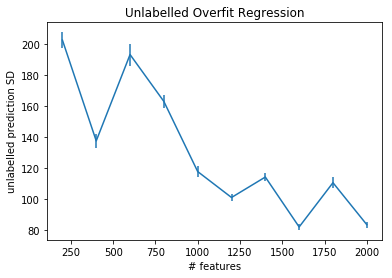

In [405]:
plt.errorbar(feat_sizes, avg_stds, yerr=std_stds)
plt.ylabel("unlabelled prediction SD")
plt.xlabel("# features")
plt.title("Unlabelled Overfit Regression")
plt.show()

## Noise Simulation

- want to check simplest case when the features do not provide any information on the response variables

### Classification sandbox

In [17]:
random_state = 3
n_informative = 0
n_train = 500
n_test = 500
weights = [0.5, 0.5]
flip_y = 0


n_features = 250
train_X, train_y, \
test_X, test_y = generate_class_data(n_train,
                                     n_test,
                                     n_informative=n_informative,
                                     n_features=n_features,
                                     weights=weights,
                                     flip_y=flip_y)
                                                       

ValueError: n_classes * n_clusters_per_class must be smaller or equal 2 ** n_informative

#### Polynomial features (n_features stays constant)

In [177]:
n_train = 500
n_test = 500
n_features = 20
random_state = 3
train_X, train_y, test_X, test_y = generate_noise_class_data(n_train,
                                                             n_test,
                                                             n_features,
                                                             random_state=random_state)
print(np.sum(train_X))
print(np.sum(test_X))
print(np.sum(train_y))
print(np.sum(test_y))
print(train_y[:5])

-276.5848939275271
-13.274462449921536
267
258
[False False False False False]


In [178]:
degrees = np.arange(1,12)


train_acc = []
test_acc = []

train_proba = []
test_proba = []
pipelines = []

for deg in degrees:
    poly_features = PolynomialFeatures(degree=deg, 
                                       include_bias=False,
                                       interaction_only=True)
    lr_model = LogisticRegression(solver='lbfgs', 
                                  penalty='none', 
                                  #C=1000,
                                  random_state=random_state,
                                  n_jobs=-1)
    lr_pipeline = Pipeline([("polynomial_features", poly_features),
                           ("logistic_regression", lr_model)])
    
    lr_pipeline.fit(train_X.copy(), train_y.copy())
    
    pipelines.append(lr_pipeline)
    
    train_acc.append(accuracy_score(train_y, lr_pipeline.predict(train_X)))
    train_proba.append(lr_pipeline.predict_proba(train_X)[:, 1])
    
    test_acc.append(accuracy_score(test_y, lr_pipeline.predict(test_X)))
    test_proba.append(lr_pipeline.predict_proba(test_X)[:, 1])
    
    print(deg)
    
print(test_acc)

1
2
3
4
5
6
7
8
9
10
11
[0.516, 0.488, 0.504, 0.496, 0.48, 0.506, 0.528, 0.524, 0.528, 0.516, 0.512]


In [188]:
print(train_acc)
for pipe in pipelines:
    print(pipe['polynomial_features'].n_output_features_)

[0.568, 0.858, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
20
210
1350
6195
21699
60459
137979
263949
431909
616665
784625


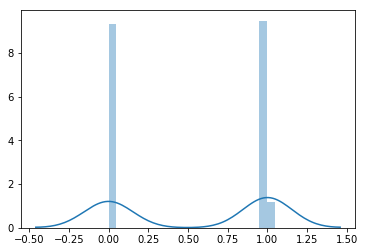

In [180]:
sns.distplot(train_proba[6], bins=np.arange(0,1.1, 0.05))

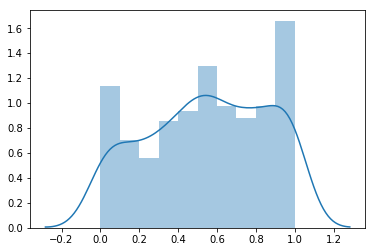

In [185]:
sns.distplot(test_proba[10], bins=np.arange(0,1.1, 0.1))

#### Increasing n_features

In [227]:
n_train = 500
n_test = 500
random_state = 3
n_features = list(np.arange(0, 2001, 100))


models = []

train_accs = []
test_accs = []

train_probas = []
test_probas = []

for deg in [1,2]:
    print("Degree: {}".format(deg))
    lr_models = []

    train_acc = []
    test_acc = []

    train_proba = []
    test_proba = []
    for n_feat in n_features[1:]:

        train_X, train_y, \
        test_X, test_y = generate_noise_class_data(n_train,
                                                   n_test,
                                                   n_feat,
                                                   random_state=random_state)

        lr_features = PolynomialFeatures(degree=deg, 
                                           include_bias=False,
                                           interaction_only=True)
        lr_pipeline = LogisticRegression(solver='lbfgs', 
                                      penalty='none', 
                                      #C=1000,
                                      random_state=random_state,
                                      n_jobs=-1)
        lr_pipeline = Pipeline([("polynomial_features", lr_features),
                               ("logistic_regression", lr_pipeline)])

        lr_pipeline.fit(train_X.copy(), train_y.copy())

        lr_models.append(lr_pipeline)

        train_acc.append(accuracy_score(train_y, lr_pipeline.predict(train_X)))
        train_proba.append(lr_pipeline.predict_proba(train_X)[:, 1])

        test_acc.append(accuracy_score(test_y, lr_pipeline.predict(test_X)))
        test_proba.append(lr_pipeline.predict_proba(test_X)[:, 1])

        print(lr_pipeline['polynomial_features'].n_output_features_)
        
    models.append(lr_models)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_probas.append(train_proba)
    test_probas.append(test_proba)
    

Degree: 1
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
Degree: 2
5050
20100
45150
80200
125250
180300
245350
320400
405450
500500
605550
720600
845650
980700
1125750
1280800
1445850
1620900
1805950
2001000


In [228]:
print(train_accs[0])

[0.698, 0.794, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


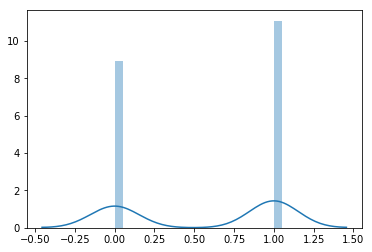

In [237]:
sns.distplot(train_probas[1][19], bins=np.arange(0,1.1, 0.05))

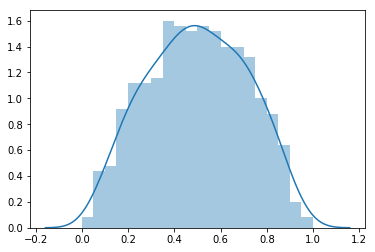

In [250]:
sns.distplot(test_probas[1][15], bins=np.arange(0,1.1, 0.05))

In [252]:
# save models, predictions

pickle.dump(models, open("../pkl/noise_class_models.pkl", "wb"), -1)
pickle.dump(train_accs, open("../pkl/noise_class_train_acc.pkl", "wb"), -1)
pickle.dump(test_accs, open("../pkl/noise_class_test_acc.pkl", "wb"), -1)

pickle.dump(train_probas, open("../pkl/noise_class_train_proba.pkl", "wb"), -1)
pickle.dump(test_probas, open("../pkl/noise_class_test_proba.pkl", "wb"), -1)

### Notes

- for polynomial features, as the number of terms increases the mass around 0.5 increases
- how to quantify the differences between "properly fit" models and "overfit" models?
- need some measure of the optimal performance
- look into Bayes optimality for classification?